In [208]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sct
import seaborn as sns
import pickle

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import RFE

from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import NearMiss
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [122]:
dfm  = pd.read_csv('estaticos_market.csv')
dfp1 = pd.read_csv('estaticos_portfolio1.csv')

In [123]:
dfp2 = pd.read_csv('estaticos_portfolio2.csv')
dfp3 = pd.read_csv('estaticos_portfolio3.csv')

In [124]:
print(dfm.shape)
print(dfp1.shape)
print(dfp2.shape)
print(dfp3.shape)

(462298, 182)
(555, 182)
(566, 2)
(265, 2)


## Análise exploratória dos dados

In [125]:
dfm.head(1)

,Unnamed: 0,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,...,43.738462,93.266667,19.166667,26.0,26.0,27.0,0.0,-3.703704,0.0,0


In [126]:
# Quantificando quantos registros em branco existem em cada dimensão
print (dfm.isnull().sum())

Unnamed: 0                                            0
id                                                    0
fl_matriz                                             0
de_natureza_juridica                                  0
sg_uf                                                 0
natureza_juridica_macro                               0
de_ramo                                               0
setor                                              1927
idade_empresa_anos                                    0
idade_emp_cat                                         0
fl_me                                                 0
fl_sa                                                 0
fl_epp                                                0
fl_mei                                                0
fl_ltda                                               0
dt_situacao                                           6
fl_st_especial                                        0
fl_email                                        

In [127]:
dfm.isnull().mean()

Unnamed: 0                                       0.000000
id                                               0.000000
fl_matriz                                        0.000000
de_natureza_juridica                             0.000000
sg_uf                                            0.000000
natureza_juridica_macro                          0.000000
de_ramo                                          0.000000
setor                                            0.004168
idade_empresa_anos                               0.000000
idade_emp_cat                                    0.000000
fl_me                                            0.000000
fl_sa                                            0.000000
fl_epp                                           0.000000
fl_mei                                           0.000000
fl_ltda                                          0.000000
dt_situacao                                      0.000013
fl_st_especial                                   0.000000
fl_email      

In [128]:
dados_faltantes = dfm.isnull().sum() # soma os dados faltantes do dataset
percentual_de_dados_faltantes = (dados_faltantes.sum()/ np.product(dfm.shape)) * 100
print ('Percentual de dados faltantes:', round (percentual_de_dados_faltantes, 2), '%')

Percentual de dados faltantes: 65.97 %


## Tratamento dos dados

Remove colunas com mais de 80% dos registros nulos
https://stackoverflow.com/questions/43311555/how-to-drop-column-according-to-nan-percentage-for-dataframe

In [129]:
dfm["portifolio"] = -1;
dfm = dfm.loc[:, dfm.isnull().mean() < .8].copy()
dfm.drop(['Unnamed: 0'], axis=1, inplace=True)

In [130]:
numeric_features = dfm.select_dtypes(include=['int64', 'float64']).drop(['portifolio'], axis=1).columns
categorical_features = dfm.select_dtypes(include=['object', 'bool']).drop(['id'], axis=1).columns
dfm[categorical_features] = dfm[categorical_features].fillna(-1).astype(str)

In [131]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='0')),
    ('onehot',  OrdinalEncoder())])

preprocessorColumnTransformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [132]:
dfColumnsNaoAlteradas = pd.DataFrame(dfm[['id', 'portifolio']], columns=['id', 'portifolio'])
numeric_features.tolist() + categorical_features.tolist()
dfmColumnTransformation = pd.DataFrame(preprocessorColumnTransformer.fit_transform(dfm), columns=[numeric_features.tolist() + categorical_features.tolist()])
dfmColumnTransformation = pd.concat([dfColumnsNaoAlteradas, dfmColumnTransformation], axis=1)

In [133]:
#usar os 3 portifolios que tenho para selecionar as melhores features
dfmColumnTransformation.loc[dfmColumnTransformation.id.isin(dfp1.id).astype(int) > 0, "portifolio"] = 1
dfmColumnTransformation.loc[dfmColumnTransformation.id.isin(dfp2.id).astype(int) > 0, "portifolio"] = 2
dfmColumnTransformation.loc[dfmColumnTransformation.id.isin(dfp3.id).astype(int) > 0, "portifolio"] = 3

In [134]:
dfmColumnTransformation.portifolio.value_counts()

-1    461020
 1       555
 2       458
 3       265
Name: portifolio, dtype: int64

In [136]:
dfmColumnTransformation.shape

(462298, 67)

In [137]:
dfmParaRfe = dfmColumnTransformation[dfmColumnTransformation["portifolio"] != -1]
dfmParaRfe.portifolio.value_counts()

1    555
2    458
3    265
Name: portifolio, dtype: int64

In [138]:
X, y = dfmParaRfe.drop(columns = ['portifolio', 'id'], axis=1), dfmParaRfe['portifolio']

#### Procura os melhores parametros para o modelo

In [139]:
rf = Pipeline(steps=[('classifier', RandomForestClassifier())])
param_grid = { 
    'classifier__n_estimators': [200, 500],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth' : [4,5,6,7,8],
    'classifier__criterion' :['gini', 'entropy']}
CV = GridSearchCV(rf, param_grid, n_jobs= 1)
                  
CV.fit(X, y)  
print(CV.best_params_)    
print(CV.best_score_)

"\nrf = Pipeline(steps=[('classifier', RandomForestClassifier())])\nparam_grid = { \n    'classifier__n_estimators': [200, 500],\n    'classifier__max_features': ['auto', 'sqrt', 'log2'],\n    'classifier__max_depth' : [4,5,6,7,8],\n    'classifier__criterion' :['gini', 'entropy']}\nfrom sklearn.model_selection import GridSearchCV\nCV = GridSearchCV(rf, param_grid, n_jobs= 1)\n                  \nCV.fit(X, y)  \nprint(CV.best_params_)    \nprint(CV.best_score_)\n"

In [140]:
model = RandomForestClassifier(criterion= 'entropy', max_depth= 7, max_features= 'sqrt', n_estimators= 200)

#### RFE pare tentar achar as melhores features

In [141]:
selector = RFE(model, n_features_to_select = 20, step=0.05)
selector = selector.fit(X, y)

#### tentar achar as melhores selecionadas pelo RFE 

Text(0.5, 1.0, 'Importância de cada feature')

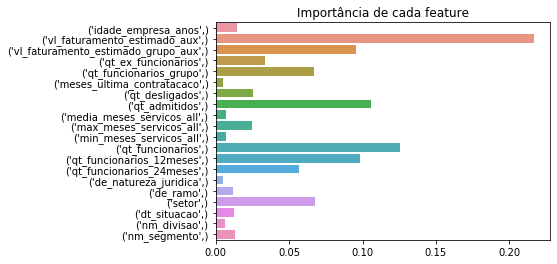

In [142]:
#dessas as que tem mais importancia
model.fit(X[X.columns[selector.support_]], y)
importances = pd.Series(data=model.feature_importances_, index=dfmColumnTransformation[X.columns[selector.support_]].columns)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada feature')

In [143]:
#print([i for i in model.feature_importances_ if i > 0 ])
#len(dfmColumnTransformation[X.columns[selector.support_]].columns)
dfColumnsNaoAlteradas = pd.DataFrame(dfmColumnTransformation[['id', 'portifolio']], columns=['id', 'portifolio'])
dfmColumnSelecionadas = pd.DataFrame(dfmColumnTransformation[X.columns[selector.support_]], columns=dfmColumnTransformation[X.columns[selector.support_]].columns.tolist())
dfmColumnTransformationToSave = pd.concat([dfColumnsNaoAlteradas, dfmColumnSelecionadas], axis=1)
dfmColumnTransformationToSave.head(2)

,id,portifolio,"(idade_empresa_anos,)","(vl_faturamento_estimado_aux,)","(vl_faturamento_estimado_grupo_aux,)","(qt_ex_funcionarios,)","(qt_funcionarios_grupo,)","(meses_ultima_contratacaco,)","(qt_desligados,)","(qt_admitidos,)",...,"(min_meses_servicos_all,)","(qt_funcionarios,)","(qt_funcionarios_12meses,)","(qt_funcionarios_24meses,)","(de_natureza_juridica,)","(de_ramo,)","(setor,)","(dt_situacao,)","(nm_divisao,)","(nm_segmento,)"
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,-1,0.468908,0.078677,-0.045443,1.144956,-0.039391,-0.238011,1.135431,0.733125,...,-0.135055,0.205791,0.205988,0.195622,60.0,11.0,3.0,2710.0,33.0,11.0
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,-1,-0.882484,-0.018523,-0.045866,-0.056385,-0.039736,-0.049031,-0.054958,-0.042536,...,-0.047562,-0.021950,-0.021627,-0.024330,17.0,21.0,5.0,6812.0,4.0,4.0


In [144]:
dfmColumnTransformationToSave.to_csv('estaticos_market_tratado.csv', index=False)

## Avaliação de algoritmos

In [158]:
def avaliacaoAlgoritmoPorNearMiss(dfm):
    nr = NearMiss()
    X, y = nr.fit_sample(dfm.drop(['portifolio', 'id'], axis=1), dfm.portifolio)
    print(sns.countplot(x=y))
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, stratify=y)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("accuracy_score por NearMiss => " +  accuracy_score(y_test, y_pred).astype(str))
    
def avaliacaoAlgoritmoPorSMOTE(dfm):
    smt = SMOTE()
    X, y = smt.fit_sample(dfm.drop(['portifolio', 'id'], axis=1), dfm.portifolio)
    print(sns.countplot(x=y))
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, stratify=y)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("accuracy_score por SMOTE => " +  accuracy_score(y_test, y_pred).astype(str))    

In [182]:
#vou usar o portifolio 1 para fazer a avaliação do algoritmo de classificação
dfmTratado  = pd.read_csv('estaticos_market_tratado.csv')
dfmTratado["portifolio"] = -1;
dfmTratado.loc[dfmColumnTransformation.id.isin(dfp1.id).astype(int) > 0, "portifolio"] = 1

AxesSubplot(0.125,0.125;0.775x0.755)
accuracy_score por NearMiss => 0.9856115107913669
AxesSubplot(0.125,0.125;0.775x0.755)
accuracy_score por SMOTE => 0.8347872414151565


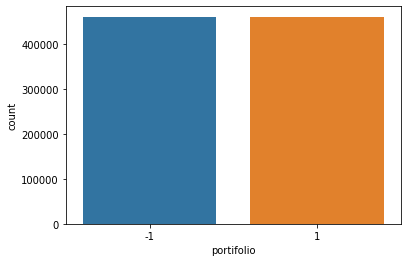

In [177]:
avaliacaoAlgoritmoPorNearMiss(dfmTratado)
avaliacaoAlgoritmoPorSMOTE(dfmTratado)

## Treinamento do modelo

In [189]:
dfmTratado["portifolio"] = -1;
def treinaModelo(dfPortifolio, testSize = 0.01):
    dfmTratado.loc[dfmColumnTransformation.id.isin(dfPortifolio.id).astype(int) > 0, "portifolio"] = 1
    nr = NearMiss()
    X, y = nr.fit_sample(dfmTratado.drop(['portifolio', 'id'], axis=1), dfmTratado.portifolio)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size=testSize, stratify=y)
    model.fit(X_train, y_train)
    return X_train, X_test, y_train, y_test

treinaModelo(dfp2)
dfTreino = dfmTratado[dfmTratado["portifolio"] == -1]
print(dfTreino.shape)

(461732, 22)


####  Retorno da predição após o treinamento

In [190]:
y_pred = model.predict(dfTreino.drop(['portifolio', 'id'], axis=1))
y_pred

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

### Avaliação de Performance do Modelo

In [205]:
def avaliacaoPerformanceModelo(dfPortifolio, testSize = 0.33):
    X_train, X_test, y_train, y_test = treinaModelo(dfPortifolio, testSize)
    predAvaliacao = model.predict(X_test)
    print("accuracy_score\n-----------------------------------\n")
    print(accuracy_score(y_test, predAvaliacao))
    print("\n\n")
    print("classification_report\n----------------------------\n")
    print (classification_report(y_test, predAvaliacao))
    print("\n")
    print("crosstab\n-----------------------------------------\n")
    print (pd.crosstab(y_test, predAvaliacao, rownames=['Real'], colnames=['Predito'], margins=True))

##### Avaliar portifolio 3

In [206]:
avaliacaoPerformanceModelo(dfp3, testSize = 0.33)

accuracy_score
-----------------------------------

0.9748953974895398



classification_report
----------------------------

              precision    recall  f1-score   support

          -1       0.98      0.97      0.97       239
           1       0.97      0.98      0.98       239

    accuracy                           0.97       478
   macro avg       0.98      0.97      0.97       478
weighted avg       0.98      0.97      0.97       478



crosstab
-----------------------------------------

Predito   -1    1  All
Real                  
-1       231    8  239
1          4  235  239
All      235  243  478


### Visualização dos Resultados

##### Lista de Ids de Leads mais aderentes dado as características dos clientes presentes no portfólio do usuário 

In [185]:
y_pred = model.predict(dfTreino.drop(['portifolio', 'id'], axis=1))

In [186]:
dfRetornoLeadsMaisAderentes = dfTreino[y_pred == 1].copy()
print(dfRetornoLeadsMaisAderentes.shape)
dfRetornoLeadsMaisAderentes[["id"]]

(1980, 22)


,id
79,8a584390e7b2fba5ef33a51b2f8fd63bd202194db3e5ee...
123,6e292487550f4b68a5a710b1512039761b07cdb9d11257...
428,1f122f16a4182b7474c29e5c49d6598ee10b86d2ab115f...
537,a69961fa35f49e63f74cecf303437758b72a833371eea3...
645,59d43a34290fd77e9b35e6eb5374ca7bd3ef67a2e1c507...
693,5b8e57173320b1ae3cb45733782609c27b6ee9e8ef2c46...
1443,c24d6219b125d9dbea52c431f6dc6122ee76c94cce8987...
1669,d3da982ee47e130c79a9262eaf08d7093b5797ed16893f...
2080,7de1743c7ed76964be2ae6ae429aac23393dd3e30de429...
2533,0d32ce2de82e59e3b7acf88f84c1c591069e07ec2668ba...


#### Salva o modelo

In [209]:
pickle.dump(model, open('modelo.sav', 'wb'))